[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ibs-lab/cedalion/blob/multimodal_sigdecomp_tc/examples/machine_learning/51_multimodal_source_decomposition_on_synthetic_fNIRS-EEG_data.ipynb)

# Multimodal Source Decomposition Methods on Simulated fNIRS-EEG data

In this tutorial, we show how different multimodal source-decomposition methods can be used on an example toy fNIRS-EEG dataset to extract the underlying common (neural) sources. In particular, we cover Canonical Correlation Analysis (CCA), its regularized and temporally-embedded variants, and the multimodal Source Power Co-Modulation (mSPoC) algorithm from [[Dähne, et.al. 2013](https://ieeexplore.ieee.org/document/6472075)]. All these methods can be found in the `cedalion.sigdecomp.multimodal` package.

In [34]:
# This cells setups the environment when executed in Google Colab.
try:
    import google.colab
    !curl -s https://raw.githubusercontent.com/ibs-lab/cedalion/dev/scripts/colab_setup.py -o colab_setup.py
    # Select branch with --branch "branch name" (default is "dev")
    %run colab_setup.py
except ImportError:
    pass

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp

# Limit display to show 3 items at each edge, then "..."
np.set_printoptions(threshold=20, edgeitems=2)

# To reaload packages and modules automatically.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Define helper plotting function for later use

def plot_source_comparisson(sx_power, sy, sx_power_model, sy_model, corrx, corry, corrxy, title):
    """ Plot comparison between original and reconstructed sources."""

    fig, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

    ax[0].plot(sx_power.time, sx_power, label='sx_power', color='red')
    ax[0].plot(sx_power_model.time, sx_power_model, label='sx_power reconstructed', color='blue')
    ax[0].set_title('Sx | Correlation: {:.3f}'.format(corrx))
    ax[0].set_ylabel('Amplitude')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(sy.time, sy, label='sy', color='green')
    ax[1].plot(sy_model.time, sy_model, label='sy reconstructed', color='orange')
    ax[1].set_title('Sy | Correlation: {:.3f}'.format(corry))
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Amplitude')
    ax[1].legend()
    ax[1].grid()

    plt.suptitle(f'{title} Reconstructed Sources | Correlation: {corrxy:.3f}', fontsize=16)
    plt.tight_layout()
    plt.show()

## Simulated Dataset 

For the simulated data we follow a small extension of the approach presented in [[Dähne et al. 2013](https://ieeexplore.ieee.org/document/6472075)] that can be found whithin Cedalion, inside the `sim.synthetic_toy_datasets.synthetic_fnirs_eeg` module.

In [37]:
from cedalion.sim.synthetic_toy_datasets.synthetic_fnirs_eeg import BimodalToyDataSimulation, standardize

#### Brief toy data description:
EEG ($x$) and fNIRS ($y$) recordings are generated from a pseudo-random linear mixing forward model. Sources $s_x, s_y$ are split into background (independent between modalities) and target (co-modulate between modalities). Each EEG background source is generated from random oscillatory signals in a given frequency band multiplied by a slow-varying random amplitude-modulation function. The latter is the envelope of $s_x$, and it serves as an estimate for the source bandpower timecourse. fNIRS background sources are generated from slow-varying random amplitude-modulation functions, using the same approach as for the envelope of $s_x$. The target sources are built using the same technique, but this time the same envelope used to modulate $s_x$ is used as the fNIRS source $s_y$. The $s_x$ target sources can be also time-lagged (`dT` $> 0$) with respect to the target source $s_y$ to simulate physiological delays between modalities. Upon simulation, fNIRS sources and recordings are downsampled to a new sampling interval, a.k.a. epochs, `T_epoch`.

Random background mixing matrices $A_x$ and $A_y$ are built using normal distributions, while we use Gaussian Radial Basis Functions (RBF) plus white noise to generate the ones for target sources. The latter approach gives the spatial patterns a more realistic local structure, by using the same center for the RBF for $A_x$ and $A_y$. 

The SNR can be tuned with the `gamma` parameter, which regulates the relative strength between target source and background source contributions in channel space. The exact relationship between SNR [dB] and `gamma` is given by $20 \ log_{10}(\gamma)$.

The EEG recordings and their channel-wise powerband timecourses can be accesed via the `x` and `x_power` attributes. The former has the full sampling rate used during simulation (i.e. `rate`), while the latter has been downsampled so to be in the same time basis as the fNIRS recordings, `y`, and therefore directly comparable. The simulated target sources are contained in `sx_t` and `sy_t`, each of them with their own sampling rate, and the powerband timecourse of the former source can be obtained from `sx_power`.

Finally, the simulated data can be fed into a small preprocessing step, where each dataset and source is standardized (zero mean and unit variance) and split into train and test sets.

Random seed set as 137
Simulating sources...
Finished
SNR: -4.44


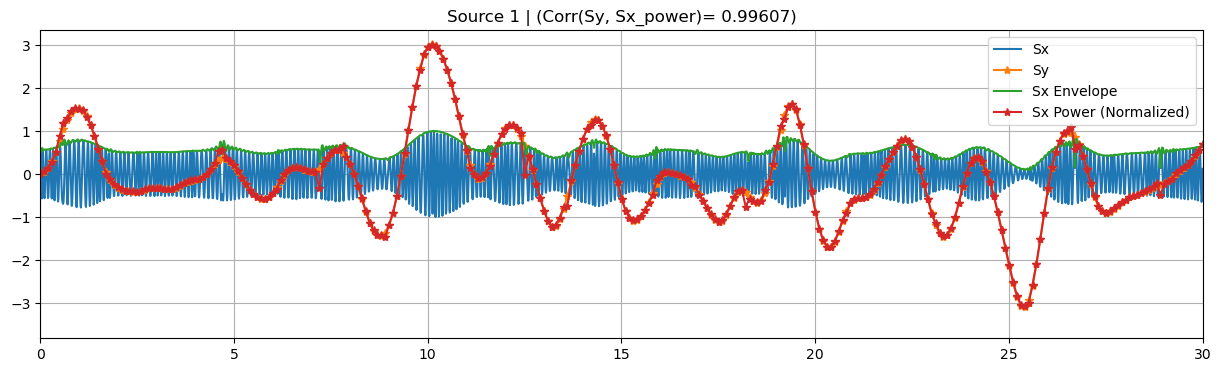

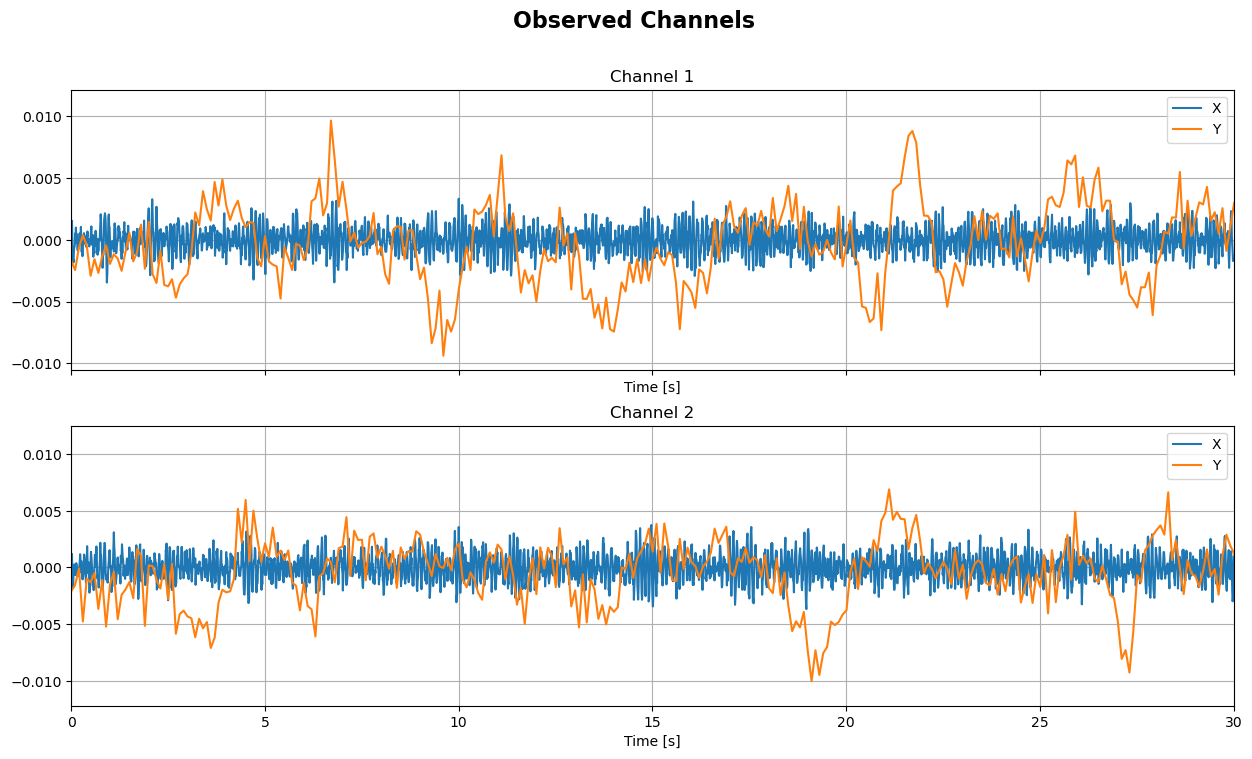

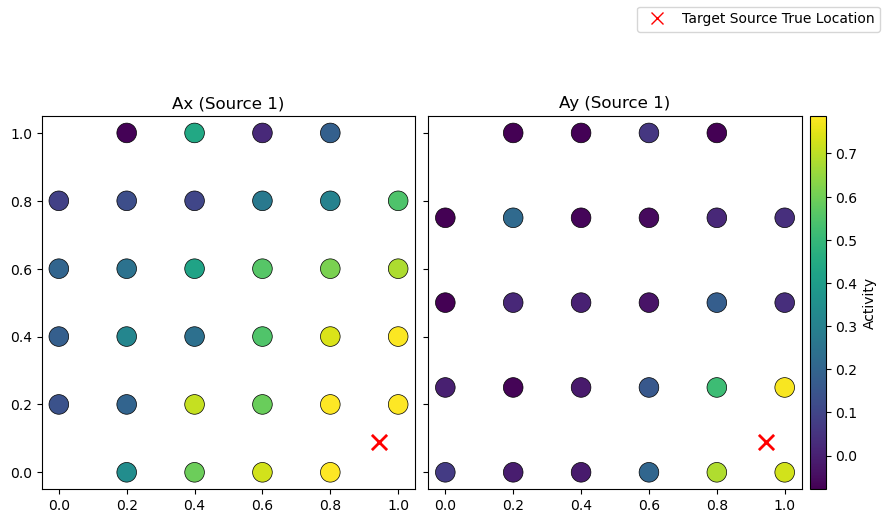

In [38]:
# Configuration dictionary for the simulation (equivalently, can be loaded from a YAML file)
config_dict = {'Ny': 28,  # Number of channels
               'Nx': 32,
               'Ns_all': 100,  # Total number of sources
               'Ns_target': 1,  # Number of target sources
               'T': 300,  # Total simulation time (s)
               'T_epoch': 0.1,  # Length of epochs / Y sampling interval (s)
               'rate': 100,  # Sampling rate (Hz)
               'f_min': 8,  # Frequency band (Hz)
               'f_max': 12,
               'dT': 0,  # Time lag between target sources
               'invert_sy': False,  # Invert sy target source
               'gamma_e': .5,  # Noise strenght factor
               'gamma': .6,  # SNR parameter 
               'ellx': .5,  # Width of RBF 
               'elly': .2,
               'sigma_noise': 0.1,  # RBF white noise strength
               } 

# Create a simulation object with the configuration dictionary
sim = BimodalToyDataSimulation(config_dict, seed=137, mixing_type='structured')
SNR = 20 * np.log10(sim.args.gamma)  # Calculate SNR in dB
print(f'SNR: {SNR:.2f}')

# Plot target sources, channels, and mixing patterns (set xlim for better visualization)
sim.plot_targets(xlim=(0, 30))
sim.plot_channels(N=2, xlim=(0, 30))
sim.plot_mixing_patterns()

# Run small preprocessing step to standardize and split the data into train and test sets
train_test_split = 0.8  # Proportion of data to use for training
preprocess_data_dict = sim.preprocess_data(train_test_split)
x_train, x_test = preprocess_data_dict['x_train'], preprocess_data_dict['x_test']
x_power_train, x_power_test = preprocess_data_dict['x_power_train'], preprocess_data_dict['x_power_test']
y_train, y_test = preprocess_data_dict['y_train'], preprocess_data_dict['y_test']
sx, sx_power, sy = preprocess_data_dict['sx'], preprocess_data_dict['sx_power'], preprocess_data_dict['sy']

## Regularized CCA

Canonical Correlation Analysis (CCA) looks for linear projections that maximize the correlation between two datasets $X$ and $Y$. In certain scenarios, such as when dealing with high-dimensionality problems (more features than samples) or co-linearities between observations, or when looking for sparse or smooth solutions, regularized CCA is expected to achieve a better performance on the source reconstruction task and help with interpretability. Some of the most well-established regularization/penalty terms are the L1-norm, leading to Sparse CCA, the L2-norm, leading to Ridge CCA, and their combination, known as ElasticNet CCA. 

All these methods can be found as classes in the `cca_models` module inside the multimodal package: `CCA`, `SparseCCA`, `RidgeCCA`, and `ElasticNetCCA`. The latter contains the first three models as particular cases, so each of them can be also instantiated by picking specific values of the regularization parameters in the ElasticNetCCA class. Its implementation is based on [[Parkhomenki et al. 2009](https://www.degruyterbrill.com/document/doi/10.2202/1544-6115.1406/html)].

We now show example use cases of these classes utilizing the toy-model fNIRS-EEG data simulated above. To this end, we will use the bandpower timecourse of $x$ as one of the inputs, and the timecourse of $y$ as the second one, both sharing the same sampling rate. The reason behind this choice is that, from a neuroscientific perspective, we expect these quantities to co-modulate, rather than their directy timecourses.

In [39]:
from cedalion.sigdecomp.multimodal.cca_models import CCA, SparseCCA, RidgeCCA, ElasticNetCCA, StructuredSparseCCA

### CCA

We have four optional parameters when initializing `CCA`: `N_components` is the number of components to extract. If `None`, the number of components is set to the minimum number of features between modalities. `max_iter` refers to the maximum number of iterations for the algorithm and `tol` regulates the tolerance for convergence by checking the norm of the difference between successive vector solutions during iteration. `scale` (bool) determines whether to scale the data during normalization to unit variance or just center it.

In [40]:
# Initialize model
cca = CCA(N_components=1, 
          max_iter=1000, 
          tol=1e-6, 
          scale=True)

We can now fit the model to some (x_train, y_train). Each of the input datasets need to be an `xr.DataArray` object with exactly two dimensions: one for features and the other one for samples. Both x and y datasets need to share the same sample dimension name and shape, while features can be different. The dimension naming can be specified with optional parameters. By default, the sample dimension is expected to be named 'time' and the feature dimensions 'channel'.

In [41]:
# Fit model
cca.fit(x_power_train, y_train, 
        sample_name='time', 
        featureX_name='channel', 
        featureY_name='channel')

display(cca.Wx)

<xarray.DataArray (channel: 32, CCA_X: 1)> Size: 256B
array([[ 0.00688436],
       [ 0.07599408],
       ...,
       [-0.00521229],
       [-0.02266829]])
Coordinates:
  * channel  (channel) <U3 384B 'X1' 'X2' 'X3' 'X4' ... 'X29' 'X30' 'X31' 'X32'
  * CCA_X    (CCA_X) <U3 12B 'Sx1'

The learned filters, available via `cca.Wx`, and `cca.Wy`, can be used to transform a different pair (x_test, y_test). This test set must have the exact same feature dimension (name and shape) as the train data. The sample dimension should be the same between x_test and y_test, and its name must coincide with the one used during training. The number of samples, however, can be different between train and test sets.

In [42]:
# Transform data
sx_power_cca, sy_cca = cca.transform(x_power_test, y_test)

print(f"Latent space dimensions: {cca.latent_featureX_name, cca.latent_featureY_name}")
sx_power_cca

Latent space dimensions: ('CCA_X', 'CCA_Y')


<xarray.DataArray (time: 600, CCA_X: 1)> Size: 5kB
array([[-7.52241255e-02],
       [ 4.46777452e-04],
       ...,
       [ 4.16556828e-01],
       [ 1.13498100e+00]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 299.8 299.9 300.0
  * CCA_X    (CCA_X) <U3 12B 'Sx1'

The `transform` method returns the "reconstructed sources", with the same sample dimension as the test input but with a new "latent_feature" dimension, generated automatically from the class/model name.

If the decomposition was performed successfully, the reconstructed sources should be close to the ground truth ones used in the linear forward model of the simulated data.

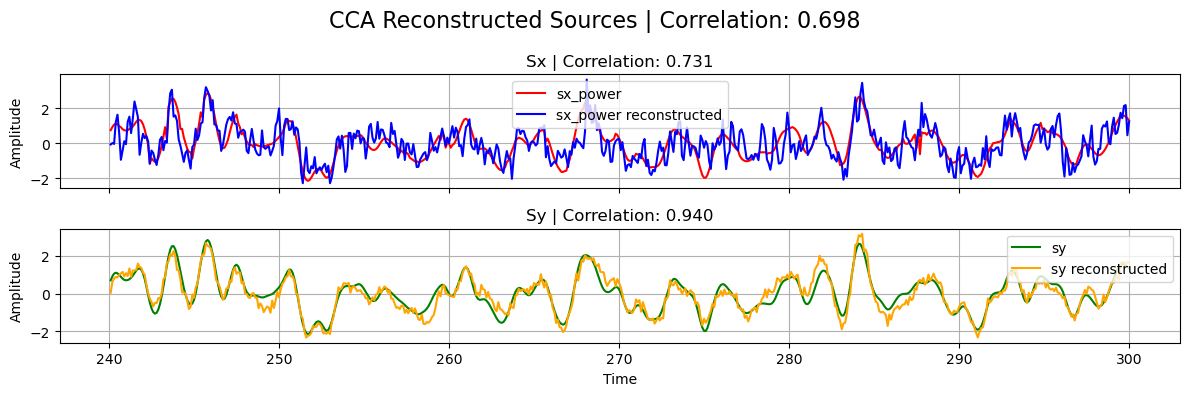

In [43]:
# Normalize
sx_power_cca = standardize(sx_power_cca).T
sy_cca = standardize(sy_cca).T

# Calculate correlations
corrxy = np.corrcoef(sx_power_cca[0], sy_cca[0])[0, 1]
corrx = np.corrcoef(sx_power_cca[0], sx_power[0])[0, 1]
corry = np.corrcoef(sy_cca[0], sy[0])[0, 1]

# Plot results
plot_source_comparisson(sx_power[0], sy[0], sx_power_cca[0], sy_cca[0], corrx, corry, corrxy, title='CCA')

### Sparse CCA, Ridge CCA, and ElasticNet CCA

`ElasticNetCCA` admits the same optional parameters as `CCA` on top of `l1_reg` and `l2_reg` to encode the regularization parameteres for the L1 and L2 penalty terms, respectively. These parameters take a list of the form $[ \lambda_x, \lambda_y]$, containing the regularization parameters for $W_x$, and $W_y$, respectively. If, instead, a float $\lambda$ is passed, then $\lambda_x=\lambda_y=\lambda$. L1 and L2 parameters need to be non-negative, with zero-values corresponding to no regularization. Additionally, `l1_reg` components must be smaller than $0.5$, while `l2_reg` components are unbounded. `SparseCCA` is a sub-class of `ElasticNetCCA`, obtained by setting `l2_reg=0` on the latter. Analogously, `RidgeCCA` is equivalent to `ElasticNetCCA` with `l1_reg=0`. By choosing both regularizers to be zero, we recover the same `CCA` implementation we explored above.

With these regularized methods we can achieve better performance compared to standard CCA, even in lower SNR scenarios, as long as we make the right choice of hyperparamters. The latter gives us more flexibility, but requires a bit of extra work to achieve the optimal model's performance. For such a hyperparameter exploration, for instance, one can run a small random or grid search together with cross-validation in a validation set. 

For the sake of simplicity, we won't follow that approach here, but rather show how the performance of `ElasticNetCCA` on the test set varies with different hyperparameter configurations. In particular, by looking at the `l1_reg=_l2_reg=0` in parameter space, we can see the increase in performance compared with CCA.

Best L1 regularization: 0.04583, Best L2 regularization: 0.83333
Max correlation: 0.706, Correlation X: 0.734, Correlation Y: 0.945
CCA correlation (L1=L2=0): 0.698, Correlation X: 0.731, Correlation Y: 0.940


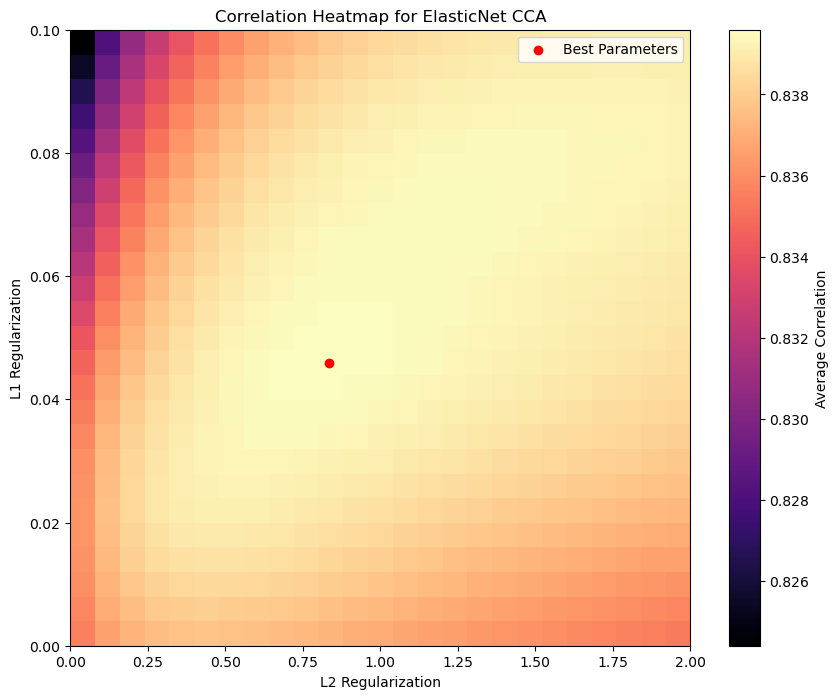

In [44]:
# Define ranges for L1 and L2 parameters
l1_reg_list = np.linspace(0, 0.1, 25)
l2_reg_list = np.linspace(0, 2, 25)

# Initialize a list to store correlations regularization parameters
correlations_list = np.zeros((len(l1_reg_list), len(l1_reg_list), 3))

# Loop through parameters 
for i, l1 in enumerate(l1_reg_list):
    for j, l2 in enumerate(l2_reg_list):

        # Initialize (default names for sample and feature dimensions is 'time' and 'channel')
        elastic_cca = ElasticNetCCA(N_components=1, 
                                    l1_reg=[l1, l1],  # L1 regularization parameter (same for both datasets) 
                                    l2_reg=l2)  # L2 regularization parameter (same for both datasets)

        # Fit model
        elastic_cca.fit(x_power_train, y_train)
        
        # Transform data
        sx_power_elastic_cca, sy_elastic_cca = elastic_cca.transform(x_power_test, y_test)
        
        # Normalize
        sx_power_elastic_cca = standardize(sx_power_elastic_cca).T[0]
        sy_elastic_cca = standardize(sy_elastic_cca).T[0]

        # Calculate correlations
        corrxy_elastic = np.corrcoef(sx_power_elastic_cca, sy_elastic_cca)[0, 1]
        corrx_elastic = np.corrcoef(sx_power_elastic_cca, sx_power)[0, 1]
        corry_elastic = np.corrcoef(sy_elastic_cca, sy)[0, 1]

        correlations_list[i, j] = [corrxy_elastic, corrx_elastic, corry_elastic]

# Find (L1, L2) configuration with highest avarage correlation between corrx and corry
corr_avg = np.mean(correlations_list[:, :, 1:], axis=-1)
i, j = np.unravel_index(np.argmax(corr_avg), corr_avg.shape)
max_corrxy, max_corrx, max_corry = correlations_list[i, j]
best_l1_reg = l1_reg_list[i]
best_l2_reg = l2_reg_list[j]

# CCA correlation with L1=L2=0
cca_corr = correlations_list[0, 0, :]  

print(f"Best L1 regularization: {best_l1_reg:.5f}, Best L2 regularization: {best_l2_reg:.5f}")
print(f"Max correlation: {max_corrxy:.3f}, Correlation X: {max_corrx:.3f}, Correlation Y: {max_corry:.3f}")
print(f"CCA correlation (L1=L2=0): {cca_corr[0]:.3f}, Correlation X: {cca_corr[1]:.3f}, Correlation Y: {cca_corr[2]:.3f}")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_avg, cmap='magma', aspect='auto', origin='lower',
           extent=[l2_reg_list[0], l2_reg_list[-1], l1_reg_list[0], l1_reg_list[-1]],
           interpolation='nearest')
plt.colorbar(label='Average Correlation')
plt.xlabel('L2 Regularization')
plt.ylabel('L1 Regularization')
plt.title('Correlation Heatmap for ElasticNet CCA')
plt.scatter(best_l2_reg, best_l1_reg, color='red', label='Best Parameters')
plt.legend()
plt.show()

For the other regularization models, initializing, fitting and transforming work in the same way:

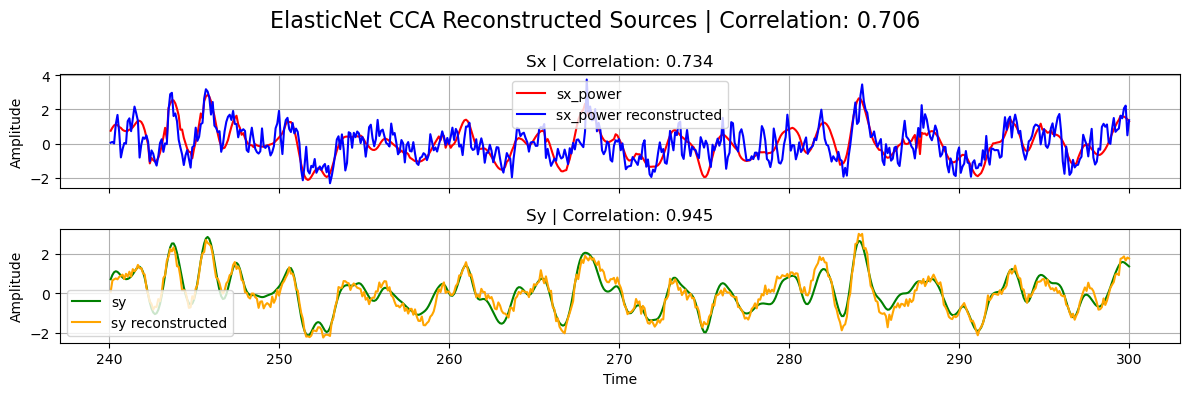

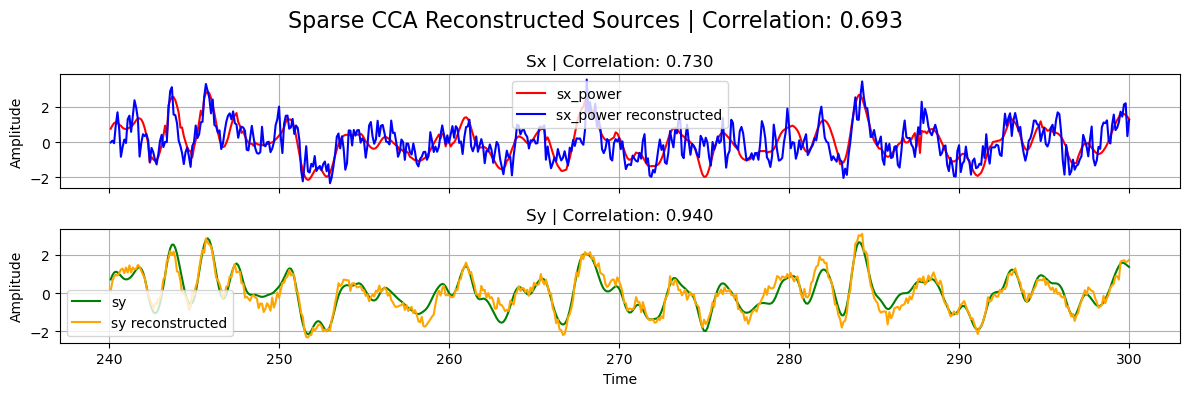

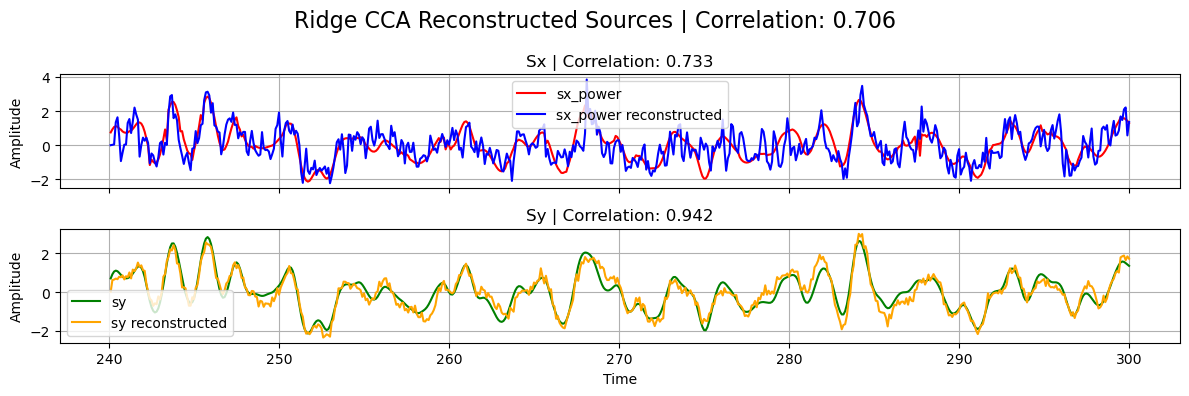

In [45]:
# Initialize models (use optimal parameters found above)
elasticnet_cca = ElasticNetCCA(N_components=1,
                                l1_reg=best_l1_reg,  # Use optimal L1, L2 found above
                                l2_reg=best_l2_reg)

sparse_cca = SparseCCA(N_components=1, l1_reg=best_l1_reg)  # Equals ElasticNetCCA with l1_reg=best_l1_reg and l2_reg=0
ridge_cca = RidgeCCA(N_components=1, l2_reg=best_l2_reg)  # Equals ElasticNetCCA with l1_reg=0 and l2_reg=best_l2_reg

# Fit models
elasticnet_cca.fit(x_power_train, y_train)
sparse_cca.fit(x_power_train, y_train)
ridge_cca.fit(x_power_train, y_train)

# Transform data
sx_power_elastic, sy_elastic = elasticnet_cca.transform(x_power_test, y_test)
sx_power_sparse, sy_sparse = sparse_cca.transform(x_power_test, y_test)
sx_power_ridge, sy_ridge = ridge_cca.transform(x_power_test, y_test)

# Normalize
sx_power_elastic = standardize(sx_power_elastic).T[0]
sy_elastic = standardize(sy_elastic).T[0]

sx_power_sparse = standardize(sx_power_sparse).T[0]
sy_sparse = standardize(sy_sparse).T[0]

sx_power_ridge = standardize(sx_power_ridge).T[0]
sy_ridge = standardize(sy_ridge).T[0]


# Calculate correlations
corrxy_elastic = np.corrcoef(sx_power_elastic, sy_elastic)[0, 1]
corrx_elastic = np.corrcoef(sx_power_elastic, sx_power)[0, 1]
corry_elastic = np.corrcoef(sy_elastic, sy)[0, 1]

corrxy_sparse = np.corrcoef(sx_power_sparse, sy_sparse)[0, 1]
corrx_sparse = np.corrcoef(sx_power_sparse, sx_power)[0, 1]
corry_sparse = np.corrcoef(sy_sparse, sy)[0, 1]

corrxy_ridge = np.corrcoef(sx_power_ridge, sy_ridge)[0, 1]
corrx_ridge = np.corrcoef(sx_power_ridge, sx_power)[0, 1]
corry_ridge = np.corrcoef(sy_ridge, sy)[0, 1]

# Plot
plot_source_comparisson(sx_power[0], sy[0], sx_power_elastic, sy_elastic, corrx_elastic, corry_elastic, corrxy_elastic, title='ElasticNet CCA')
plot_source_comparisson(sx_power[0], sy[0], sx_power_sparse, sy_sparse, corrx_sparse, corry_sparse, corrxy_sparse, title='Sparse CCA')
plot_source_comparisson(sx_power[0], sy[0], sx_power_ridge, sy_ridge, corrx_ridge, corry_ridge, corrxy_ridge, title='Ridge CCA')

### Structured Sparse CCA (ssCCA)

ElasticNet regularization can be modified to include contextual information about the local structure of the dataset, leading to structured CCA. This is particularly relevant in neuroimaging, where features (e.g. channels or brain regions) follow specific spatial distributions. One way of incorporating this prior information is to modify the L2-norm penalty term on the filters $W$ via $||W||_2^2 \rightarrow W^T L W$ for some matrix $L$ that captures the local dependencies among features. When this structure contraint is combined with an L1 penalization, the resulting method is called structured sparse CCA (ssCCA) and is implemented in Cedalion as the `StructuredSparseCCA` class, following [[Chen et al. 2013](https://academic.oup.com/biostatistics/article/14/2/244/377057)].

This class admits the same parameters as `ElasticNetCCA` together with `Lx` and `Ly`, corresponding to structure matrices used for each dataset. The latter need to be square matrices of shapes $(Nx, Nx)$ and $(Ny, Ny)$, in terms of the number of features of each dataset. This time, the `l2_reg` parameter regulates the strength of the structured penalty term, and must be non-negative but otherwise unbounded.

One popular choice for such structure contraint is the Laplacian matrix, which is used as a graph representation of the dataset, in which features (channels) are the nodes, and (weighted) edges indicate which and how features are connected. We now show a simple example of a Laplacian matrix, build via an adjacency matrix that uses a binary nearest-neighbord strategy. 

In [46]:
# Helper function to build Laplacian matrix
def build_laplace(nodes, eps):
    """Builds Laplacian matrix of a graph, whose nodes are the components of the 1D vector nodes, 
    by giving unit weight to connected nodes only if they are close enough. The latter condition
    is determined by comparing the 2-norm between nodes and eps.
    """
    
    N = len(nodes)
    Adj = np.zeros([N, N])  # Adjacency matrix
    D = np.eye(N)  # Degree matrix
    
    for i, xi in enumerate(nodes):
        for j, xj in enumerate(nodes):
            if i == j:  # Skip diagonal entries
                continue
            are_close = np.linalg.norm(xi - xj) < eps
            Adj[i, j] = 1 if are_close else 0

        D[i, i] = np.sum(Adj[i])
    
    L = D - Adj  # Laplace matrix
    
    return L, Adj

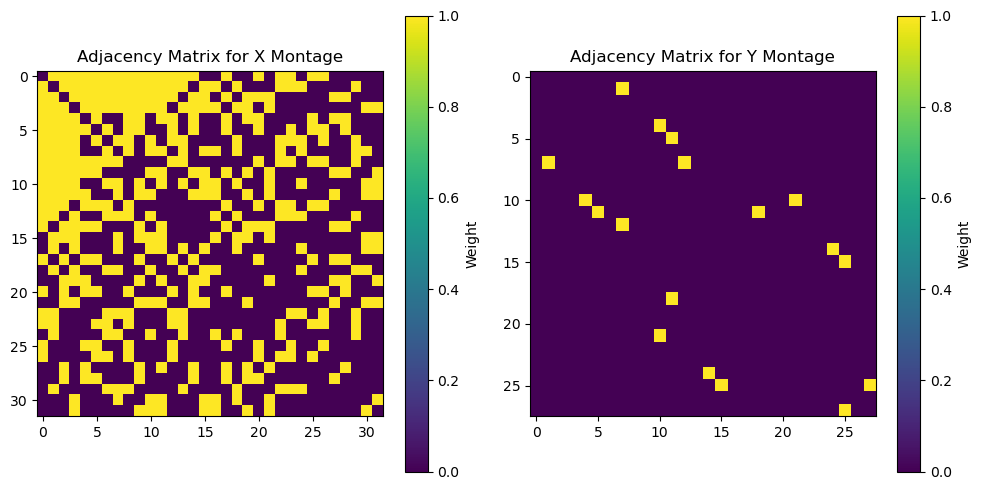

In [47]:
# Read channel positions from simulation
x_channels_pos = sim.x_montage.values
y_channels_pos = sim.y_montage.values

# Build Laplacian matrix from each montage (eps thresholds chosen by small experimentation)
Lx, Adjx = build_laplace(x_channels_pos, eps=sim.args.ellx)
Ly, Adjy = build_laplace(y_channels_pos, eps=sim.args.elly)

# Plot Adjacency matrices
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Adjx, cmap='viridis', interpolation='nearest')
plt.title('Adjacency Matrix for X Montage')
plt.colorbar(label='Weight')
plt.subplot(1, 2, 2)
plt.imshow(Adjy, cmap='viridis', interpolation='nearest')
plt.title('Adjacency Matrix for Y Montage')
plt.colorbar(label='Weight')
plt.tight_layout()

The choice of structure/Laplace matrix introduces yet another layer of complexity to the model, which needs further fine-tunning to achieve its optimal performance. Since making an exhaustive investigation is beyond the scope of this tutorial notebook, here we just chose the nearest-neighbor thresholds to coincide with the ground truth RBF width used in the simulated mixing matrices, and picked the same regularization parameters as for `ElasticNetCCA` above. Initialization, fitting, and transformation follows the same logic as before:

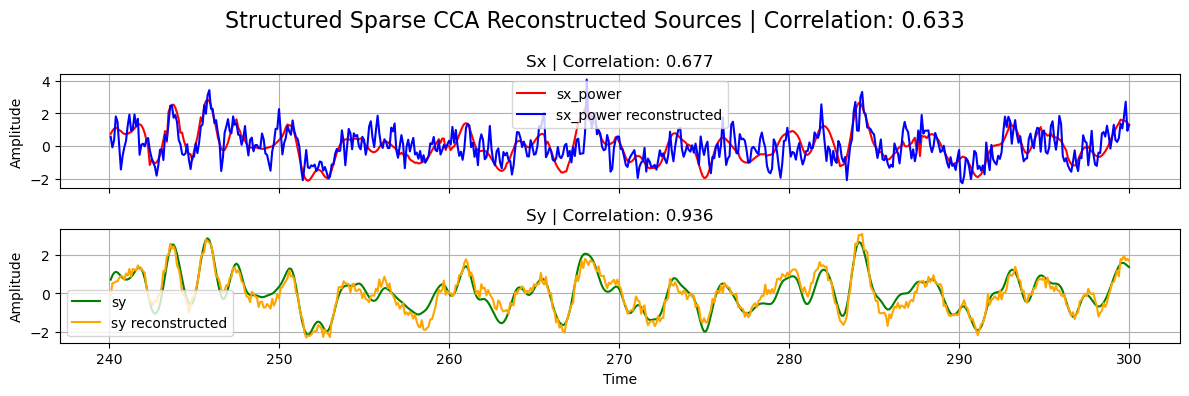

In [48]:
sscca = StructuredSparseCCA(N_components=1,
                            l1_reg=best_l1_reg,  # Use optimal L1, L2 found above
                            l2_reg=best_l2_reg,
                            Lx=Lx,  # Laplacian matrix for X montage
                            Ly=Ly)  # Laplacian matrix for Y montage

# Fit model
sscca.fit(x_power_train, y_train)
# Transform data
sx_power_sscca, sy_sscca = sscca.transform(x_power_test, y_test)
# Normalize
sx_power_sscca = standardize(sx_power_sscca).T[0]
sy_sscca = standardize(sy_sscca).T[0]
# Calculate correlations
corrxy_sscca = np.corrcoef(sx_power_sscca, sy_sscca)[0, 1]
corrx_sscca = np.corrcoef(sx_power_sscca, sx_power)[0, 1]
corry_sscca = np.corrcoef(sy_sscca, sy)[0, 1]
# Plot
plot_source_comparisson(sx_power[0], sy[0], sx_power_sscca, sy_sscca, corrx_sscca, corry_sscca, corrxy_sscca, title='Structured Sparse CCA')

From the learned weights, `Wx` and `Wy`, one can estimate the spattial patterns `Ax` and `Ay` via a regression method [[Haufe et al. 2014](https://www.sciencedirect.com/science/article/pii/S1053811913010914?via%3Dihub)]. These quantities should be close to the original mixing matrices used in the linear forward model of the simulated data. Structured regularization is particularly promising for such a reconstruction task given the incorporation of spatial information during the decomposition:

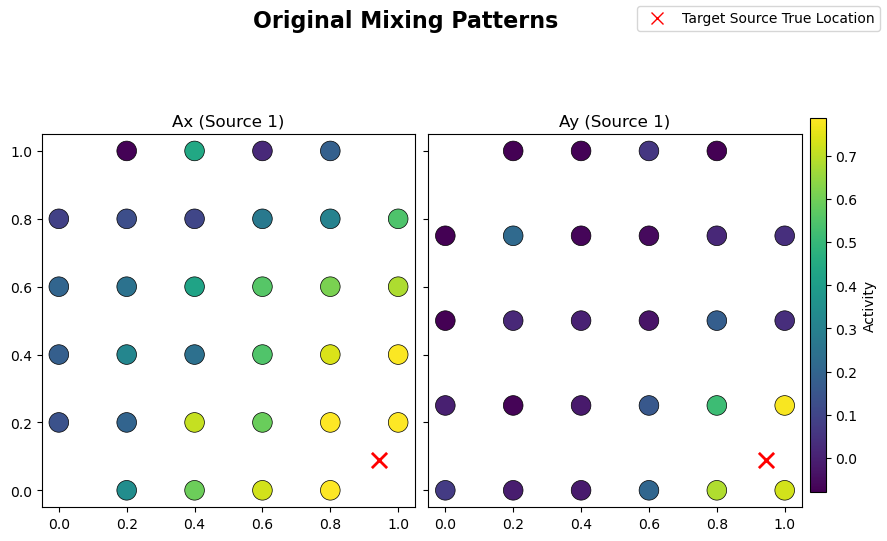

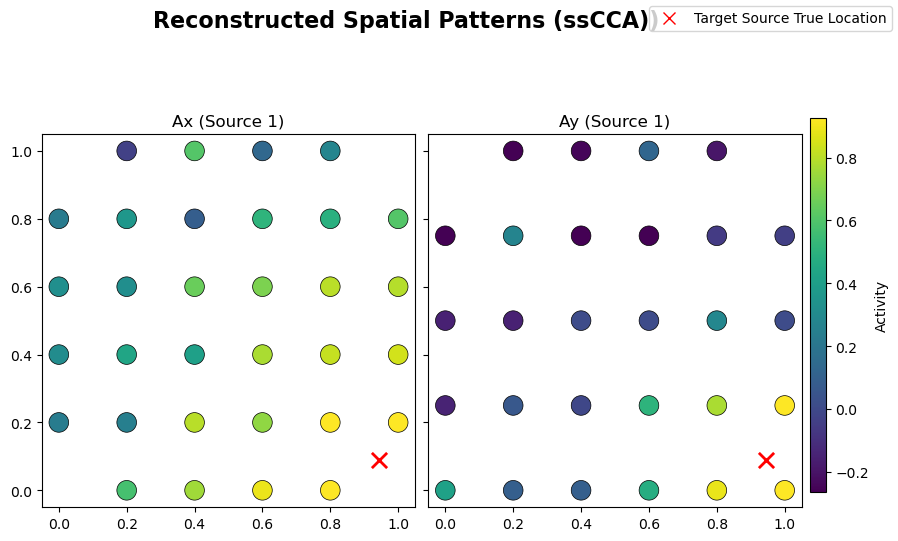

In [49]:
# Helper function to estimate spatial patterns from learned weights via regression approach
def compute_spatial_pattern_from_weight(X_xr, W_xr, sample_name='time', feature_name='channel'):
    
    # Bring to standard order
    X_xr = X_xr.transpose(sample_name, feature_name)
    W_xr = W_xr.transpose(feature_name, ...)
    
    # Work with numpy arrays from now on
    N = len(X_xr[sample_name])
    X = X_xr.data
    W = W_xr.data
    # Covariance matrix for X
    C = (X.T @ X) / (N - 1)
    # Covariance matrix for reconstructed sources
    Cs = W.T @ C @ W
    # Estimated spattial pattern
    A = C @ W @ sp.linalg.pinv(Cs)

    # Bring to DataArray format\
    A = xr.DataArray(A, 
                     dims=W_xr.dims, 
                     coords=W_xr.coords)
    
    return A

# Compute spatial patterns from learned weights for ssCCA
Ax_sscca = compute_spatial_pattern_from_weight(x_test, sscca.Wx)
Ay_sscca = compute_spatial_pattern_from_weight(y_test, sscca.Wy)

# Normalize
Ax_sscca /= Ax_sscca.max()
Ay_sscca /= Ay_sscca.max()

# Plot original mixing patterns
sim.plot_mixing_patterns(title='Original Mixing Patterns')
# Plot estimated spatial patterns
sim.plot_mixing_patterns(Ax=Ax_sscca.values, Ay=Ay_sscca.values, title='Reconstructed Spatial Patterns (ssCCA))')

### Additional Functionalities

Apart from the functionalities already covered for the regularized and standard CCA implementations, there are few addtional features that are worth mentioning. Given their usage are rather straightforward, we leave the exploration to the curious reader.

#### Multiple Components

So far we just covered the one-unit algorithms, i.e. we extracted only one component/source. As mentioned above, all these methods can be used to extract several components by changing the value of the `N_component` parameter. That value cannot be bigger than the minimum between the number of X and Y features. The way these extra components are extracted is by following a deflation approach, where at each iteration the contribution from the previous component is removed from the input matrix entering the decomposition.

In [50]:
# Example case of multiple components CCA
cca_multiple_comp = CCA(N_components=10)
cca_multiple_comp.fit(x_power_train, y_train)
display(cca_multiple_comp.Wy)

<xarray.DataArray (channel: 28, CCA_Y: 10)> Size: 2kB
array([[-3.58103745e-02, -1.13980824e-01, ..., -3.19207986e-02,
        -2.78956666e-01],
       [ 3.18748431e-04,  3.10923103e-01, ..., -9.03916670e-02,
        -1.08926971e-01],
       ...,
       [ 1.41845120e-02,  2.95289219e-01, ...,  1.70429471e-01,
        -4.42639104e-02],
       [ 2.95061610e-01, -3.34295706e-01, ..., -3.02201767e-02,
         7.97666742e-01]])
Coordinates:
  * channel  (channel) <U3 336B 'Y1' 'Y2' 'Y3' 'Y4' ... 'Y25' 'Y26' 'Y27' 'Y28'
  * CCA_Y    (CCA_Y) <U4 160B 'Sy1' 'Sy2' 'Sy3' 'Sy4' ... 'Sy8' 'Sy9' 'Sy10'

#### Partial Least Squares (PLS)
 
PLS is a multimodal source-decomposition algorithm very similar to CCA. The latter maximizes correlation between the projected views, while PLS maximizes covariance. From a practical point of view, PLS can be obtained from CCA by sending the covariance matrices $C_x$ and $C_y$ to the identity matrices in the cost function. Therefore, both algorithms coincide when the input datasets are whitened. 

Within Cedalion, we can use these methods via the classes `PLS`, and `SparsePLS` [[Witten et al. 2009](https://academic.oup.com/biostatistics/article-lookup/doi/10.1093/biostatistics/kxp008)]. The Ridge version of PLS simply does not exist, because PLS itself can be understood as an extreme case of RidgeCCA where $\lambda_2 \to \infty$. Internally, the classes are obtained from `ElasticNetCCA` with the extra parameter `pls=True`.

In [51]:
from cedalion.sigdecomp.multimodal.cca_models import PLS, SparsePLS

In [52]:
# Example initialization of PLS and SparsePLS models
pls = PLS(N_components=1, 
          max_iter=1000, 
          tol=1e-6, 
          scale=True)
sparse_pls = SparsePLS(N_components=1, 
                       l1_reg=[0.1, 0.01])


## Temporally Embedded CCA (tCCA)

The methods covered so far assume modalities correlate instantaneously, which is certainly not the case in fNIRS-EEG fusion, for instance, where the common underlying sources are time-shifted due to hemodynamic delays. Temporally embedded CCA (tCCA) [[Biessmann et al., 2010](https://link.springer.com/article/10.1007/s10994-009-5153-3)] captures such temporal offsets. While effective, the idea is rather simple: assuming $y$ is the ”delayed” modality, $x$ is time-embedded by concatenating time-shifted copies along the feature dimension, leading to a time-embedded dataset $\tilde{x}$. The time lags must be preselected, introducing a new parameter to the model. Standard CCA (or any of the variants explored above) is then applied without further modifications on ($\tilde{x}$, $y$), yielding temporal filters that capture delayed correlations between modalities.

All the CCA variants covered above admit a temporally embedded extension, and they are implemented in Cedalion in the `tcca_models` module, which contains the classes `tCCA`, `ElasticNetTCCA`, and `StructuredSparseTCCA`. Analogously to the simultaneuously-coupled models, Sparse tCCA and Ridge tCCA can be obtained from `ElasticNetTCCA` by the right choice of `l1_reg` and `l2_reg` parameters, but in this case they do not have their own classes.

In [53]:
from cedalion.sigdecomp.multimodal.tcca_models import tCCA, ElasticNetTCCA, StructuredSparseTCCA

In order to show how these models are used, let's build a time-shifted version of the simulated data from above:

Random seed set as 137
Simulating sources...
Finished
SNR: -4.44
Time lag between target sources: 2 s


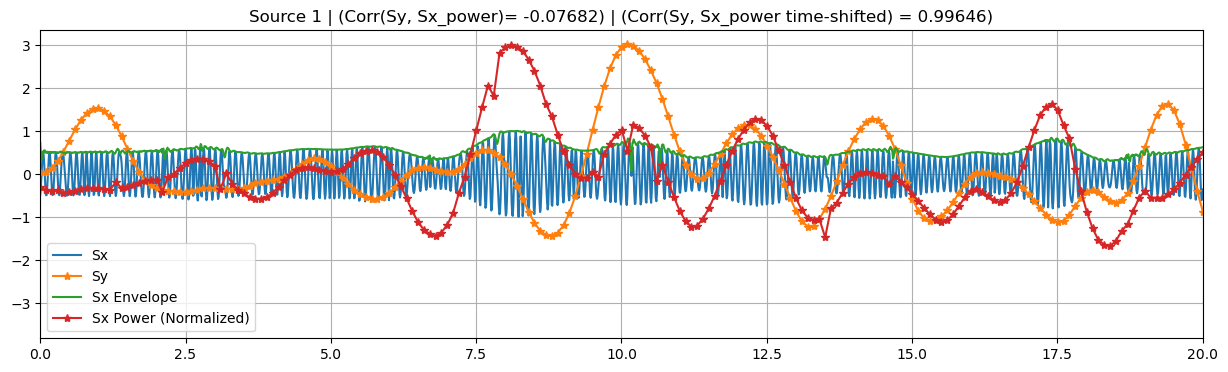

In [54]:
# Use the same configuration dictionary as before but with a non-zero time lag
config_dict['dT'] = 2  # Time lag between target sources (s)

# Simulate
sim = BimodalToyDataSimulation(config_dict, seed=137, mixing_type='structured')
SNR = 20 * np.log10(sim.args.gamma)  # Calculate SNR in dB
print(f'SNR: {SNR:.2f}')
print('Time lag between target sources:', sim.args.dT, 's')

# Plot target sourcers, channels, and mixing patterns (add xlim now to see the effect of time lag)
sim.plot_targets(xlim=(0, 20))
# sim.plot_channels(N=2)
# sim.plot_mixing_patterns()

# Run small preprocessing step to standardize and split the data into train and test sets
train_test_split = 0.8  # Proportion of data to use for training
preprocess_data_dict = sim.preprocess_data(train_test_split)
x_train, x_test = preprocess_data_dict['x_train'], preprocess_data_dict['x_test']
x_power_train, x_power_test = preprocess_data_dict['x_power_train'], preprocess_data_dict['x_power_test']
y_train, y_test = preprocess_data_dict['y_train'], preprocess_data_dict['y_test']
sx, sx_power, sy = preprocess_data_dict['sx'], preprocess_data_dict['sx_power'], preprocess_data_dict['sy']

These time-embedded classes are built on top of their simultaneuously-coupled counterparts, sharing several attributes and methods. In particular, they accept the same parameters as before, in addition to `time_shifts` and `shift_source`. 

The former must be a `Numpy` array, containing the time-lags to be applied to the $x$ modality. These lags should be non-negative float numbers within the time domain of the data. Because of the latter, a validation/consistency check of this array is carried only after fitting the model. During that validation, a time-lag $= 0$ component would be added to `time_shift` if not present already (zero-lag $x$ copy), and the resulting array is sorted in ascending order.

If the `shift_source` parameter is set to `True`, the reconstructed source $s_x$, obtained after transforming the data, is shifted by an `optimal_shift`, so it is temporally aligned with the reconstructed source $s_y$. This optimal shift attribute is estimated right after training by looking for the time-shifted x that produces the biggest correlation between reconstructed sources $s_x$ and $s_y$. Note that the `optimal_shift` attribute is available even when `shift_source=False`, so one can apply the shift a posteri if desired. It is worth clarifying that this shift is only estimated using the (train) data used during fitting.

In [55]:
# Temporal embedding parameters
dt = 1
N_lags = 5
time_shifts = np.arange(0, dt*N_lags, dt)
print(f"Time shifts: {time_shifts}")
print('True time lag between target sources:', sim.args.dT, 's')

# Initialize tCCA model
tcca = tCCA(N_components=1, 
            max_iter=1000, 
            tol=1e-6, 
            scale=True, 
            time_shifts=time_shifts,
            shift_source=True)

Time shifts: [0 1 2 3 4]
True time lag between target sources: 2 s


Fitting works in the same way as before, except that `sample_name` is assumed always to be `time`.

In [56]:
# Fit model
tcca.fit(x_power_train, y_train, 
         featureX_name='channel', 
         featureY_name='channel')

# At this point we have an estimate for the time lag between target sources
print(f"Estimated time lag between target sources during training: {tcca.optimal_shift[0]} s")
display(tcca.Wx)

Estimated time lag between target sources during training: 2.0 s


<xarray.DataArray (time_shift: 5, channel: 32, tCCA_X: 1)> Size: 1kB
array([[[ 0.02909742],
        [ 0.00324808],
        ...,
        [ 0.00277915],
        [ 0.02424533]],

       [[ 0.02922015],
        [-0.01745623],
        ...,
        [-0.01217359],
        [-0.02698547]],

       ...,

       [[ 0.00231102],
        [-0.07581282],
        ...,
        [ 0.06793825],
        [ 0.00673479]],

       [[-0.04182471],
        [-0.02473825],
        ...,
        [-0.02985189],
        [ 0.04762899]]])
Coordinates:
  * time_shift  (time_shift) int64 40B 0 1 2 3 4
  * channel     (channel) <U3 384B 'X1' 'X2' 'X3' 'X4' ... 'X30' 'X31' 'X32'
  * tCCA_X      (tCCA_X) <U3 12B 'Sx1'

The learned weights `Wx` now have an extra `time_shift` dimension, where each component contains the filters applied to the copy of $x$ shifted by that particular time-lag. `Wy` remains with the same shape as previous models.

Data transformation is also applied in the same manner, but in this case, if `shift_sources=True`, the reconstructed sources are truncated by removing the last `optimal shift` seconds, containing null values introduced by the zero-padding used during shifting.

In [57]:
# Transform data
sx_power_tcca, sy_tcca = tcca.transform(x_power_test, y_test)

display(sx_power_tcca, sx_power)

<xarray.DataArray (time: 580, tCCA_X: 1)> Size: 5kB
array([[0.76356025],
       [0.32344182],
       ...,
       [0.59467929],
       [1.65165406]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 297.8 297.9 298.0
  * tCCA_X   (tCCA_X) <U3 12B 'Sx1'

<xarray.DataArray (source: 1, time: 600)> Size: 5kB
array([[0.80191996, 0.38543529, ..., 2.18835805, 1.97710058]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 299.8 299.9 300.0
  * source   (source) <U2 8B 'S1'

Because of this sample number mismatch with the ground truth sources, we need to truncate the latter before any comparisson:

In [58]:
# Normalize
sx_power_tcca = standardize(sx_power_tcca).T[0]
sy_tcca = standardize(sy_tcca).T[0]

# Truncate ground truth sources to match the reconstructed sources
if len(sx_power_tcca) < len(sx_power.time):
    sx_power_trunc = sx_power[0, :len(sx_power_tcca)]
if len(sy_tcca) < len(sy.time):
    sy_trunc = sy[0, :len(sy_tcca)]

# Calculate correlations
corrxy_tcca = np.corrcoef(sx_power_tcca, sy_tcca)[0, 1]  # Should be low because sx is shifted!
corrx_tcca = np.corrcoef(sx_power_tcca, sx_power_trunc)[0, 1]
corry_tcca = np.corrcoef(sy_tcca, sy_trunc)[0, 1]

We also train a standard CCA method so we can compare and see the importance of capturing the time lags in the data:

In [59]:
# CCA
cca = CCA(N_components=1)
cca.fit(x_power_train, y_train)
sx_cca, sy_cca = cca.transform(x_power_test, y_test)
# Normalize
sx_cca = standardize(sx_cca).T[0]
sy_cca = standardize(sy_cca).T[0]
# Calculate correlations for CCA
corrxy_cca = np.corrcoef(sx_cca, sy_cca)[0, 1]
corrx_cca = np.corrcoef(sx_cca, sx_power)[0, 1]
corry_cca = np.corrcoef(sy_cca, sy)[0, 1]

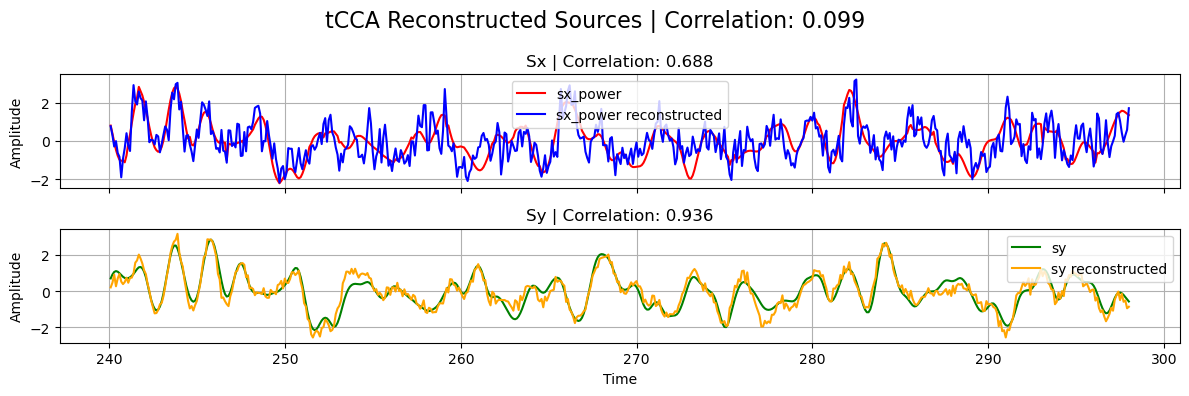

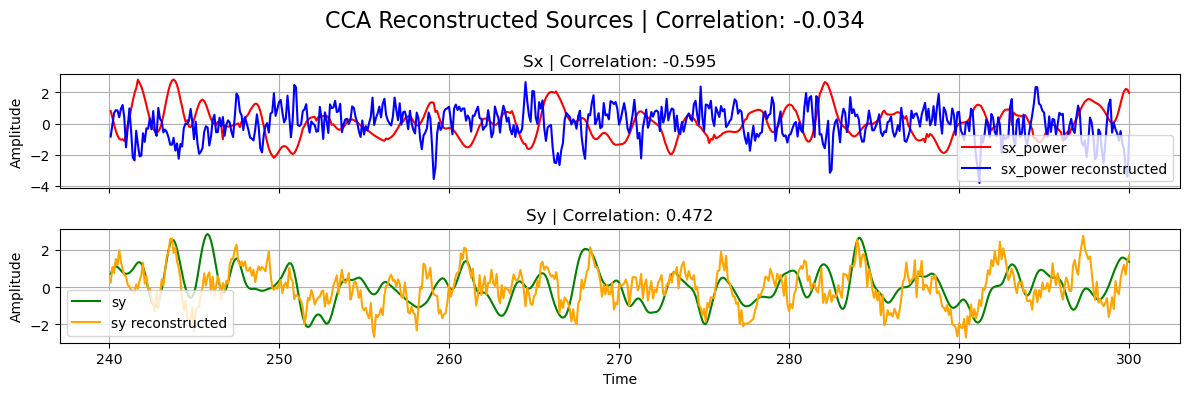

In [60]:
# Plot results
plot_source_comparisson(sx_power_trunc, sy_trunc, sx_power_tcca, sy_tcca, corrx_tcca, corry_tcca, corrxy_tcca, title='tCCA')
plot_source_comparisson(sx_power[0], sy[0], sx_cca, sy_cca, corrx_cca, corry_cca, corrxy_cca, title='CCA')

Note that, in the previous plot, the correlation between the reconstructed sources from tCCA is naturally low since $s_x$ has been shifted with the estimated `optimal_shift`. 

### Aditional Functionalities

As for the regularized CCA classes, the temporally-embedded extensions can also extract multiple components (using the same deflation algorithm), and the PLS variant can be used by settting `pls=True` during initialization.

## Multimodal Source Power Co-modulation (mSPoC)

EEG bandpower and hemodynamic responses captured by fNIRS are proven to comodulate during cognitive tasks. Conventional methods, such as CCA and its variants, however, present some limitations to integrate bandpower signals. More precisely, computing bandpower at channel level and then applying a backward linear method, as we have been doing so far, is not in line with the assumed linear generative model of EEG. mSPoC [[Dähne, et.al. 2013](https://ieeexplore.ieee.org/document/6472075)] arises as a method that avoids these
pitfalls by inverting the generative model prior to computing bandpower, and is implemented in Cedalion as the `mSPoC` class inside the `mspoc` module. 

The algorithm takes two vector-valued time series $x(t)$, and $y(e)$, which are time-aligned but have different sample dimensions `Ntx` > `Nty`. It is expected that $x(t)$ has been previously bandpassed filtered to the band of interest. It finds components $s_x(t)$ and $s_y(e)$ via linear projection of the observations, such that the covariance between the temporally-embedded,bandpower of $s_x(t)$ and the time course of $s_y(e)$ is maximized. The bandpower of $s_x(t)$ is estimated by dividing the source into non-overlapping time windows (or epochs), such that there is one window per data point $y(e)$, and computing the variance within epochs. After such operation, both signals share the same sampling rate and their cross-covariance can be calculated. The solution to the optimization problem is captured by the spatial (`Wx`, `Wy`), and temporal (`Wt`) filters.

In [61]:
from cedalion.sigdecomp.multimodal.mspoc import mSPoC

The `mSPoC` class accepts the very same parameters as the `tCCA` class, namely `N_components`, `max_iter`, `tol`, `scale`, `time_shifts`, and `shift_source`, with the addition of `N_restarts`. The latter determines the number of times the algorithm is repeated, which may find better extrema in the optimization problem, due to its stochastic nature. Typical values for `N_restarts` lie between 2 and 10, and it is recommended to choose smaller `max_iter` and bigger `tol` values, compared to simpler CCA methods, due the increased computational time required in mSPoC. As all previous CCA-based methods, mSPoC can also extract multiple components.

Random seed set as 137
Simulating sources...
Finished
SNR: -4.44
Time lag between target sources: 2 s


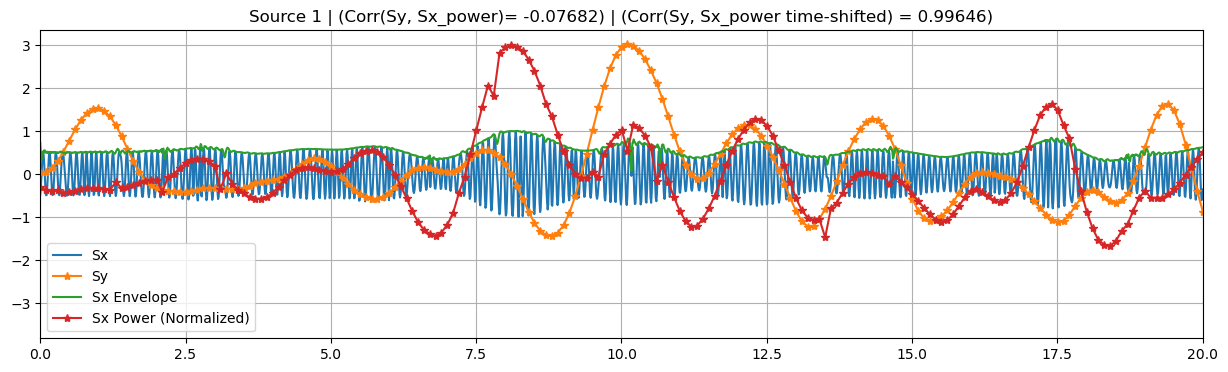

Time shifts: [0 1 2 3 4]
True time lag between target sources: 2 s


In [62]:
# We run the same simulation as for tCCA above
config_dict['dT'] = 2
sim = BimodalToyDataSimulation(config_dict, seed=137, mixing_type='structured')
SNR = 20 * np.log10(sim.args.gamma)  # Calculate SNR in dB
print(f'SNR: {SNR:.2f}')
print('Time lag between target sources:', sim.args.dT, 's')
sim.plot_targets(xlim=(0, 20))

# Run small preprocessing step to standardize and split the data into train and test sets
train_test_split = 0.8
preprocess_data_dict = sim.preprocess_data(train_test_split)
x_train, x_test = preprocess_data_dict['x_train'], preprocess_data_dict['x_test']
x_power_train, x_power_test = preprocess_data_dict['x_power_train'], preprocess_data_dict['x_power_test']
y_train, y_test = preprocess_data_dict['y_train'], preprocess_data_dict['y_test']
sx, sx_power, sy = preprocess_data_dict['sx'], preprocess_data_dict['sx_power'], preprocess_data_dict['sy']

# Temporal embedding parameters (same as for tCCA)
dt = 1
N_lags = 5
time_shifts = np.arange(0, dt*N_lags, dt)
print(f"Time shifts: {time_shifts}")
print('True time lag between target sources:', sim.args.dT, 's')

# Initialize mSPoC model
mspoc = mSPoC(N_components=1,
              N_restarts=2, 
              max_iter=100,   # Note we use much smaller values than before
              tol=1e-4, 
              scale=True, 
              time_shifts=time_shifts, 
              shift_source=True)

Fit and transform work analogously to the `tCCA` method, except that this time the number of samples in the $x$ input should be bigger than the number of $y$ samples.

In [63]:
# Fit model (sample_name fixed to be 'time' in mSPoC)
mspoc.fit(x_train, y_train,   # Note that we use x_train here, not x_power_train
          featureX_name='channel', 
          featureY_name='channel')

# At this point we have an estimate for the time lag between target sources
print(f"Estimated time lag between target sources during training: {mspoc.optimal_shift[0]} s")

# Learned filters
display(mspoc.Wx)
display(mspoc.Wt)

Estimated time lag between target sources during training: 2 s


<xarray.DataArray (channel: 32, mSPoC_X: 1)> Size: 256B
array([[ 0.00918459],
       [-0.08531889],
       ...,
       [-0.05080081],
       [-0.06184873]])
Coordinates:
  * channel  (channel) <U3 384B 'X1' 'X2' 'X3' 'X4' ... 'X29' 'X30' 'X31' 'X32'
  * mSPoC_X  (mSPoC_X) <U3 12B 'Sx1'

<xarray.DataArray (time_embedding: 5, mSPoC_T: 1)> Size: 40B
array([[-0.08030526],
       [-0.06681759],
       [ 0.9875214 ],
       [-0.08366169],
       [-0.08299807]])
Coordinates:
  * time_embedding  (time_embedding) int64 40B 0 1 2 3 4
  * mSPoC_T         (mSPoC_T) <U3 12B 'St1'

The reconstructed sources returned by `transform` correspond to the temporally-embedded bandpower of the source $s_x$, and the time course of $s_y$. Because of this choice, the outputs are directly comparable, since they have the same sampling time. As before, whenever `shift_source=True`, the time dimensions of the sources are truncated, removing the last `optimal_shift` seconds.

In [64]:
# Transform data
sx_power_mspoc, sy_mspoc = mspoc.transform(x_test, y_test)
display(sx_power_mspoc, sx_power)
display(sy_mspoc, sy)

# Normalize
sx_power_mspoc = standardize(sx_power_mspoc).T[0]
sy_mspoc = standardize(sy_mspoc).T[0]

<xarray.DataArray (time: 580, mSPoC_X: 1)> Size: 5kB
array([[0.68420679],
       [0.96722968],
       ...,
       [2.46320551],
       [2.4472856 ]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 297.8 297.9 298.0
  * mSPoC_X  (mSPoC_X) <U3 12B 'Sx1'

<xarray.DataArray (source: 1, time: 600)> Size: 5kB
array([[0.80191996, 0.38543529, ..., 2.18835805, 1.97710058]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 299.8 299.9 300.0
  * source   (source) <U2 8B 'S1'

<xarray.DataArray (time: 580, mSPoC_Y: 1)> Size: 5kB
array([[ 0.48951585],
       [ 0.80232585],
       ...,
       [-1.24250989],
       [-1.07434338]])
Coordinates:
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 297.8 297.9 298.0
  * mSPoC_Y  (mSPoC_Y) <U3 12B 'Sy1'

<xarray.DataArray (source: 1, time: 600)> Size: 5kB
array([[0.70551928, 0.92155015, ..., 1.42486491, 1.35603627]])
Coordinates:
  * source   (source) <U2 8B 'S1'
  * time     (time) float64 5kB 240.1 240.2 240.3 240.4 ... 299.8 299.9 300.0

As before, we truncate the ground truth sources for a direct comparison

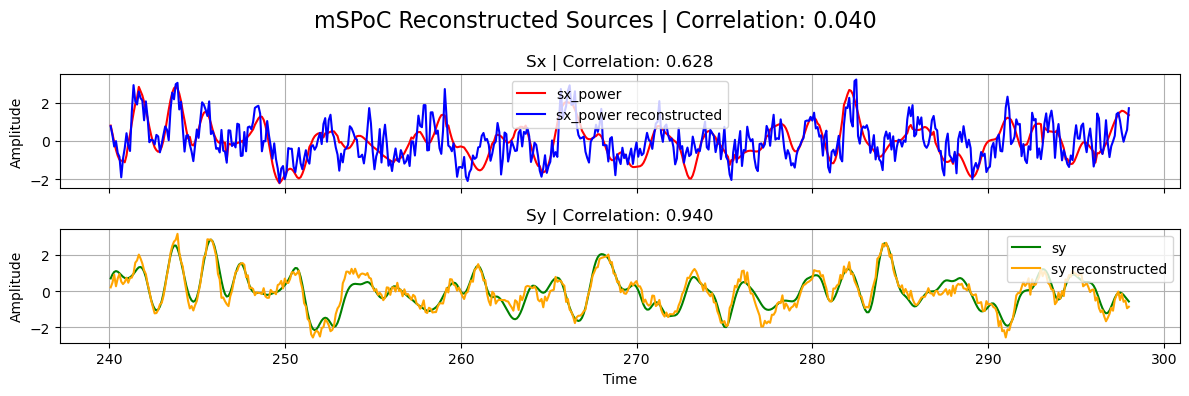

In [65]:
# Truncate ground truth sources to match the reconstructed sources
if len(sx_power_mspoc) < len(sx_power.time):
    sx_power_trunc = sx_power[0, :len(sx_power_mspoc)]
else:
    sx_power_trunc = sx_power[0]
if len(sy_mspoc) < len(sy.time):
    sy_trunc = sy[0, :len(sy_mspoc)]
else:
    sy_trunc = sy[0]

# Calculate correlations
corrxy_mspoc = np.corrcoef(sx_power_mspoc, sy_mspoc)[0, 1]  # Should be low because sx is shifted!
corrx_mspoc = np.corrcoef(sx_power_mspoc, sx_power_trunc)[0, 1]
corry_mspoc = np.corrcoef(sy_mspoc, sy_trunc)[0, 1]

# Plot results
plot_source_comparisson(sx_power_trunc, sy_trunc, sx_power_tcca, sy_tcca, corrx_mspoc, corry_mspoc, corrxy_mspoc, title='mSPoC')